# 공공데이터를 활용한 미세먼지 농도 예측 프로젝트
## 단계2. 모델링

## 0.프로젝트 소개

### (1) 수행 목표
- 미세먼지 농도를 예측하는 머신러닝 모델을 만드세요.

#### 우리가 풀어야 하는 문제는 무엇인가요?
* 서울 지역의 미세먼지 데이터와 날씨 데이터를 활용하여,
미세먼지 예측에 관련 있는 데이터 항목으로 데이터를 구성, 전처리 하여
미세먼지 농도를 예측하는 머신러닝 모델 구현


### (2) 데이터 소개

#### 1) 기본 데이터

* 학습 데이터
    * air_2021.csv : 2021년 미세먼지 데이터
    * weather_2021.csv : 2021년 날씨 데이터
* 테스트 데이터
    * air_2022.csv : 2022년 미세먼지 데이터
    * weather_2022.csv : 2022년 날씨 데이터

#### 2) 데이터셋의 변수 소개(weather_2021)

* 증기압: 증기가 고체 또는 액체와 동적 평형 상태에 있을 때 증기의 압력 (증기가 되려는 힘)
* 이슬점 온도: 불포화 상태의 공기가 냉각될 때, 포화 상태에 도달하여 수증기의 응결이 시작되는 온도
* 일조: 일정한 물체나 땅의 겉면에 태양 광선이 비치는 시간 (1시간 중 비율)
* 일사(량): 태양으로부터 오는 태양 복사 에너지가 지표에 닿는 양 (면적당 에너지 량)
* 전운량: 하늘을 육안으로 관측하여 전부 구름일 때 10, 구름이 덮고 있는 하늘의 비율에 따라 0~10
* 중하층운량: 중층과 하층에 있는 구름의 분포량(중하층 구름이 날씨에 영향 주므로 따로 표기)
* 운형(운형약어): 구름의 종류. 약어 코드로 기재됨
* 최저운고: 가장 낮은 구름의 높이
* 현상번호(국내식): 비, 소낙비, 싸락눈, 눈보라 등의 기상현상을 나타낸 코드번호
* 지면온도: 지면 0cm 온도
* 지중온도: 땅 속 온도변수1

# [Step 7] 시계열 모델 ARIMA, SARIMA

# ARIMA (AutoRegressive Integrated Moving Average)
- AutoRegressive (AR):
  - 이전 값들이 현재 값에 미치는 영향
  - AR 부분의 차수(p)는 이전 데이터 포인트 수

-  Integrated (I):
  - 데이터의 차분(d) 수를 나타냄 -> 시계열의 안정성을 확보하기 위해 사용
  - 데이터가 안정적이지 않으면 차분을 통해 안정화

- Moving Average (MA):
  - 이전의 오차 항들이 현재 값에 미치는 영향을
  - MA 부분의 차수(q)는 오차 항의 수

### ARIMA 모델은 (p, d, q) 형식으로 나타내며, 여기서 p는 AR 차수, d는 차분의 수, q는 MA 차수를 나타냄
-----------
# SARIMA (Seasonal AutoRegressive Integrated Moving Average)
- SARIMA 모델은 ARIMA 모델에 계절성을 추가한 것

- Seasonal AutoRegressive (P): 계절적 요소의 AR 차수

- Seasonal Integrated (D): 계절적 차분

- Seasonal Moving Average (Q): 계절적 MA 차수

### SARIMA 모델은 (p, d, q)(P, D, Q, s) 형식으로 나타내며, 여기서 s는 계절 주기(예: 월별 데이터의 경우 s=12)를 나타냄

In [ ]:
import os
import pickle
import logging

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from multiprocessing import Pool
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from concurrent.futures import ProcessPoolExecutor, as_completed

In [374]:
import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

In [375]:
cpu_count = os.cpu_count()
print(f"available cpus: {cpu_count}") # Colab A100 GPU

available cpus: 12


In [376]:
logging.basicConfig(level=logging.INFO)

In [404]:
class ARIMA_SARIMA_Predictor:
    def __init__(self, train_y, test_y):
        self.train_y = train_y
        self.test_y = test_y
        self.results = {}

        # Ensure the indices are correctly set for train_y and test_y
        if isinstance(self.train_y.index, pd.DatetimeIndex) and self.train_y.index.freq is None:
            self.train_y = self.train_y.asfreq('h').interpolate()
        if isinstance(self.test_y.index, pd.DatetimeIndex) and self.test_y.index.freq is None:
            self.test_y = self.test_y.asfreq('h').interpolate()

        # NaN check
        print(f"Train Data NaN Check: {self.train_y.isna().sum()}")
        print(f"Test Data NaN Check: {self.test_y.isna().sum()}")
        self.train_y = self.train_y.dropna()

        # Frequency check
        print("Train Index Frequency:", self.train_y.index.freq)
        print("Test Index Frequency:", self.test_y.index.freq)

    def fit_arima(self, order):
        """Fit an ARIMA model."""
        try:
            model = ARIMA(self.train_y['PM10_1'], order=order)
            model_fit = model.fit()
            return model_fit
        except Exception as e:
            logging.error(f"ARIMA fitting failed for order {order}: {e}")
            return None

    def fit_sarima(self, order, seasonal_order):
        """Fit a SARIMA model."""
        try:
            model = SARIMAX(
                self.train_y['PM10_1'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit()
            return model_fit
        except Exception as e:
            logging.error(f"SARIMA fitting failed for order {order} and seasonal_order {seasonal_order}: {e}")
            return None

    def evaluate_model(self, model_fit):
        """Evaluate the model's performance."""
        predictions = model_fit.forecast(steps=len(self.test_y))
        r2 = r2_score(self.test_y['PM10_1'], predictions)
        mse = mean_squared_error(self.test_y['PM10_1'], predictions)
        return r2, mse

    def evaluate_arima_params(self, params):
        """Evaluate ARIMA parameters and return AIC and fitted model."""
        order = (params['p'], params['d'], params['q'])
        model_fit = self.fit_arima(order)
        if model_fit is not None:
            return model_fit.aic, order, model_fit
        return float('inf'), None, None

    def tune_arima(self, param_grid):
        best_aic = float('inf')
        best_order = None
        best_model = None

        with ProcessPoolExecutor(max_workers=cpu_count) as executor:
            futures = {executor.submit(self.evaluate_arima_params, params): params for params in ParameterGrid(param_grid)}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Tuning ARIMA", unit="params"):
                aic, order, model_fit = future.result()
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_model = model_fit

        return best_model, best_order


    def evaluate_params(self, params):
        """Evaluate SARIMA parameters and return AIC, order, seasonal order, and fitted model."""
        order = (params['p'], params['d'], params['q'])
        seasonal_order = (params['P'], params['D'], params['Q'], params['s'])
        model_fit = self.fit_sarima(order, seasonal_order)
        if model_fit is not None:
            return model_fit.aic, order, seasonal_order, model_fit
        return float('inf'), None, None, None

    def tune_sarima(self, param_grid):
        best_aic = float('inf')
        best_order = None
        best_seasonal_order = None
        best_model = None

        with ProcessPoolExecutor(max_workers=cpu_count) as executor:
            futures = {executor.submit(self.evaluate_params, params): params for params in ParameterGrid(param_grid)}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Tuning SARIMA", unit="params"):
                aic, order, seasonal_order, model_fit = future.result()
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = model_fit

        return best_model, best_order, best_seasonal_order

    def save_weights(self, model_fit, model_type, tuned=False):
        """Save the model weights to a specific path."""
        model_path = f'./ARIMA_SARIMA_models/{model_type}_model'
        if tuned:
            model_path += '_tuned'
        model_path += '.pkl'

        os.makedirs('./ARIMA_SARIMA_models', exist_ok=True)
        with open(model_path, 'wb') as f:
            pickle.dump(model_fit.params, f)

    def tune_and_save_models(self):
        """Tune hyperparameters for ARIMA and SARIMA models and save weights."""
        arima_param_grid = {
            'p': range(0, 3),
            'd': [0, 1],
            'q': range(0, 3)
        }

        sarima_param_grid = {
            'p': range(0, 3),
            'd': [0, 1],
            'q': range(0, 3),
            'P': range(0, 2),
            'D': [0],
            'Q': range(0, 2),
            's': [12]
        }

        # Fit and evaluate untuned ARIMA
        untuned_arima_model = self.fit_arima((0, 1, 1))  # Example untuned order
        untuned_arima_r2, untuned_arima_mse = self.evaluate_model(untuned_arima_model)
        self.results['ARIMA UNTUNED'] = {'R2 Score': untuned_arima_r2, 'MSE': untuned_arima_mse}

        # Tune ARIMA
        arima_tuned_model, arima_order = self.tune_arima(arima_param_grid)
        arima_tuned_r2, arima_tuned_mse = self.evaluate_model(arima_tuned_model)
        self.results['ARIMA TUNED'] = {'Order': arima_order, 'R2 Score': arima_tuned_r2, 'MSE': arima_tuned_mse}
        self.save_weights(arima_tuned_model, 'ARIMA', tuned=True)

        # Fit and evaluate untuned SARIMA
        untuned_sarima_model = self.fit_sarima((0, 1, 1), (0, 0, 0, 12))  # Example untuned order
        untuned_sarima_r2, untuned_sarima_mse = self.evaluate_model(untuned_sarima_model)
        self.results['SARIMA UNTUNED'] = {'R2 Score': untuned_sarima_r2, 'MSE': untuned_sarima_mse}

        # Tune SARIMA
        sarima_tuned_model, sarima_order, seasonal_order = self.tune_sarima(sarima_param_grid)
        sarima_tuned_r2, sarima_tuned_mse = self.evaluate_model(sarima_tuned_model)
        self.results['SARIMA TUNED'] = {'Order': sarima_order, 'Seasonal Order': seasonal_order, 'R2 Score': sarima_tuned_r2, 'MSE': sarima_tuned_mse}
        self.save_weights(sarima_tuned_model, 'SARIMA', tuned=True)

    def display_results(self):
        """Display the evaluation results of the models in a formatted way."""
        results_df = pd.DataFrame.from_dict(self.results, orient='index')
        print("\nModel Evaluation Results:")
        print(results_df)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Plot R2 Score comparison
        results_df[['R2 Score']].plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e'])
        axes[0].set_title('R2 Score Comparison')
        axes[0].set_ylabel('R2 Score')
        axes[0].set_xlabel('Model')
        axes[0].tick_params(axis='x', rotation=45)

        # Plot MSE comparison
        results_df[['MSE']].plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
        axes[1].set_title('Mean Squared Error Comparison')
        axes[1].set_ylabel('MSE')
        axes[1].set_xlabel('Model')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        for model_name, metrics in self.results.items():
            # Skip refitting if you already have fitted models stored
            if 'ARIMA' in model_name:
                model_fit = self.fit_arima(metrics.get('Order', (0, 1, 1)))  # Fit ARIMA model if needed
            else:
                model_fit = self.fit_sarima(metrics.get('Order', (0, 1, 1)), metrics.get('Seasonal Order', (0, 0, 0, 12)))  # Fit SARIMA model if needed

            plt.figure(figsize=(10, 6))
            plt.plot(self.train_y.index, self.train_y['PM10_1'], label='Train', color='blue')
            plt.plot(self.test_y.index, self.test_y['PM10_1'], label='Test', color='orange')
            plt.plot(self.test_y.index, model_fit.forecast(steps=len(self.test_y)), label='Forecast', color='green')
            plt.title(f'{model_name} Forecast')
            plt.xlabel('Date')
            plt.ylabel('PM10')
            plt.legend()
            plt.show()


In [405]:
tmp_ARIMA_train_y = pd.read_csv('./data/ARIMA_train_y.csv')
tmp_ARIMA_train_y['time'] = pd.to_datetime(tmp_ARIMA_train_y['time'])
ARIMA_train_y = tmp_ARIMA_train_y.set_index('time', inplace=False)[['PM10_1']]
ARIMA_train_y

,PM10_1
time,
2021-10-02 00:00:00,9.0
2021-10-02 01:00:00,9.0
2021-10-02 02:00:00,10.0
2021-10-02 03:00:00,11.0
2021-10-02 04:00:00,11.0
...,...
2021-09-30 18:00:00,35.0
2021-09-30 19:00:00,34.0
2021-09-30 20:00:00,30.0


In [406]:
tmp_ARIMA_test_y = pd.read_csv('./data/ARIMA_test_y.csv')
tmp_ARIMA_test_y['time'] = pd.to_datetime(tmp_ARIMA_test_y['time'])
ARIMA_test_y = tmp_ARIMA_test_y.set_index('time', inplace=False)[['PM10_1']]
ARIMA_test_y

,PM10_1
time,
2022-01-02 00:00:00,34.0
2022-01-02 01:00:00,35.0
2022-01-02 02:00:00,33.0
2022-01-02 03:00:00,33.0
2022-01-02 04:00:00,32.0
...,...
2022-03-31 18:00:00,11.0
2022-03-31 19:00:00,10.0
2022-03-31 20:00:00,11.0


In [407]:
ARIMA_train_y.info()
ARIMA_test_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8432 entries, 2021-10-02 00:00:00 to 2021-09-30 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM10_1  8432 non-null   float64
dtypes: float64(1)
memory usage: 131.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049 entries, 2022-01-02 00:00:00 to 2022-03-31 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM10_1  2049 non-null   float64
dtypes: float64(1)
memory usage: 32.0 KB


In [ ]:
adfuller(ARIMA_train_y, autolag='AIC')

(-9.832836069143045,
 4.9843397874794125e-17,
 37,
 8394,
 {'1%': -3.431129282926983,
  '5%': -2.8618843894420043,
  '10%': -2.5669533136339995},
 58647.908319318645)

In [409]:
def ADF_test(data):
	# ADF 실시
    results = adfuller(data, autolag='AIC')

    # 통계량
    s = results[0]
    # p-value
    p = results[1]
    # 기각역
    cv = results[4]

    # 출력
    print('-'*30)
    print('Augemented Dickey-Fuller Test')
    print('H0 : 단위근이 존재한다 (비정상 시계열)')
    print('Ha : 단위근이 없다 (정상 시계열)')
    print('Critical Values : {}'.format(cv))
    print('-'*30)
    print('Test Statistics : {:.4f}'.format(s))
    print('p-value : {:.4f}'.format(p))
    print('-'*30)

# ADF 실행
ADF_test(ARIMA_train_y)

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.431129282926983, '5%': -2.8618843894420043, '10%': -2.5669533136339995}
------------------------------
Test Statistics : -9.8328
p-value : 0.0000
------------------------------


In [410]:
predictor = ARIMA_SARIMA_Predictor(ARIMA_train_y, ARIMA_test_y)

Train Data NaN Check: PM10_1    0
dtype: int64
Test Data NaN Check: PM10_1    0
dtype: int64
Train Index Frequency: <Hour>
Test Index Frequency: <Hour>


In [411]:
predictor.tune_and_save_models()

Tuning SARIMA:  29%|██▉       | 21/72 [00:10<00:45,  1.13params/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Tuning SARIMA:  31%|███       | 22/72 [00:12<01:00,  1.21s/params]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Tuning SARIMA:  33%|███▎      | 24/72 [00:15<01:00,  1.26s/params]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to con


Model Evaluation Results:
                R2 Score         MSE      Order Seasonal Order
ARIMA UNTUNED  -0.323645  731.087032        NaN            NaN
ARIMA TUNED    -0.006402  555.864566  (2, 0, 2)            NaN
SARIMA UNTUNED -0.323635  731.081605        NaN            NaN
SARIMA TUNED   -0.404733  775.873983  (1, 0, 2)  (1, 0, 1, 12)


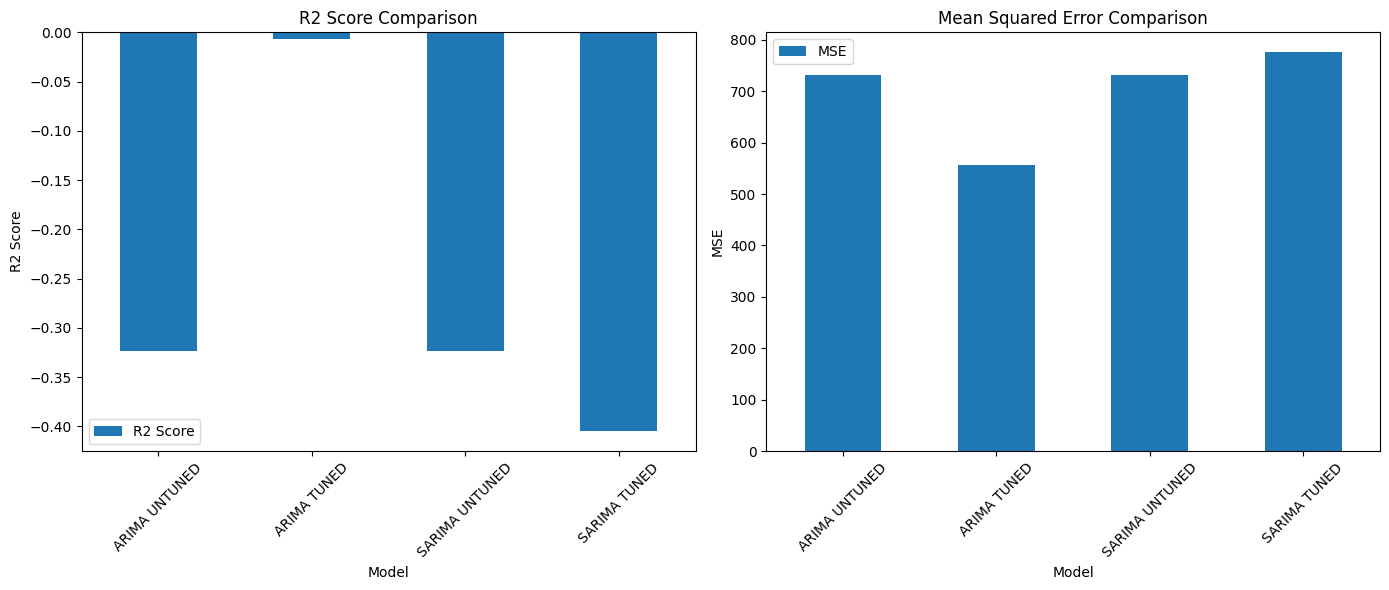

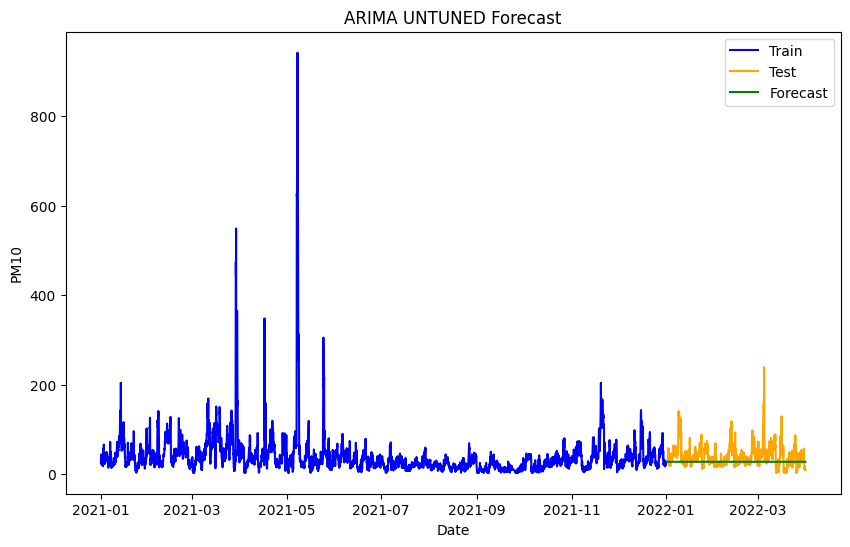

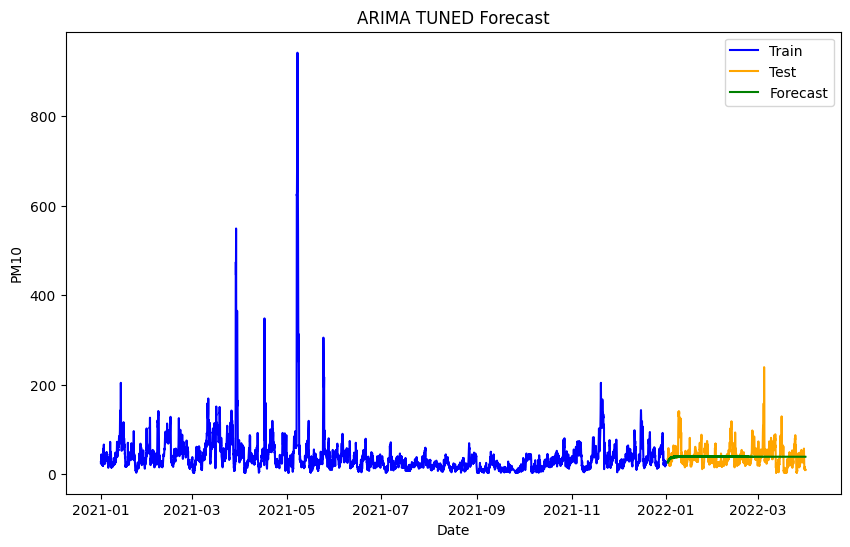

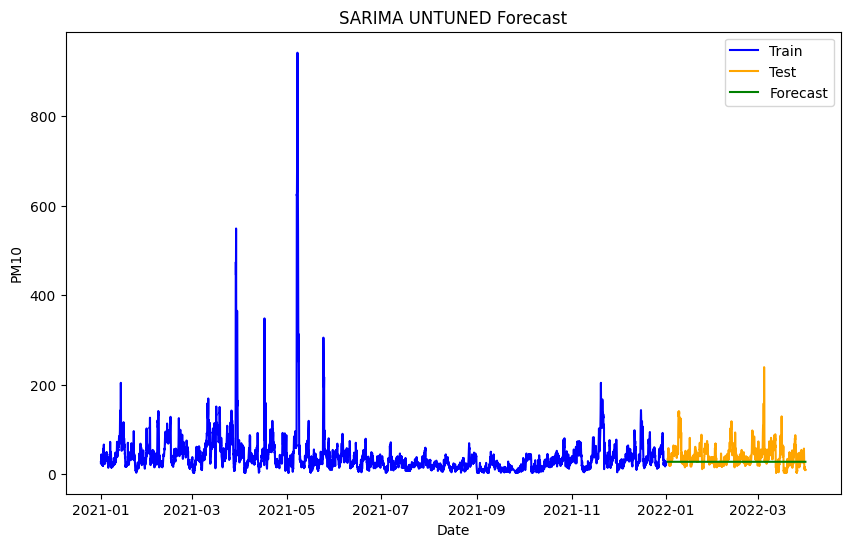

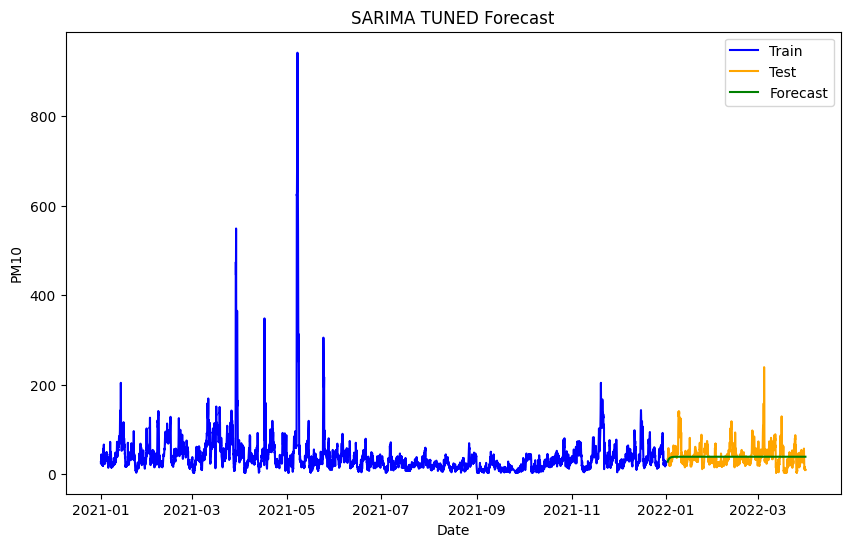

In [412]:
predictor.display_results()

# Discussion

### ARIMA와 SARIMA 모델을 사용하여 예측하려고 했으나, 데이터가 1년치로 제한되어 있음
- 특히 SARIMA는 계절성 파라미터가 중요한데, 데이터가 최소 2년 이상의 길이를 갖추어야 안정적인 계절성을 학습할 수 있음 </br>
->  따라서 1년치 데이터만으로는 계절적 변화를 충분히 반영할 수 없음

### RESULT
정상성을 확인하고 Unit Root(단위근)가 존재하지 않아 정상 시계열로 판단되었음에도 불구하고 ARIMA/SARIMA의 특성상 제대로 된 예측을 위해서는 1년치가 아닌 더 긴 데이터가 필요하다. </br>
따라서, ARIMA와 SARIMA는 현 데이터에 대한 예측 모델로 적합하지 않다.